In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import astropy
from astropy.io import fits
from astropy.stats import sigma_clip
from numpy.random import randn
from numpy import mean
from numpy import ma
import warnings
warnings.filterwarnings('ignore')

In [2]:
def reject_outliers(data, m=2):
    #print(data)
    #print(' ')
    stdev = np.nanstd(data)
    mean = np.nanmean(data)
    median = np.nanmedian(data)
    Min = median - stdev * m
    Max = median + stdev * m
    #print(Min, Max)
    for p, point in enumerate(data):
        if point < Min: data[p]=np.nan
        if point > Max: data[p]=np.nan
    #print(data)
    #print(' ')
    return data

In [3]:
filters=['vv','bb','uu','w1','m2','w2']
#filters=['w2']


apcor=[1.086,1.086,1.10,1.11,1.12,1.15]

comps=['1','01','2','02','3','03','4','04','5','05','6','06','7','07','8','08','9','09'] #,'10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35']
# 36-40 have been removed so they can be used for galaxy contaminated comparison stars but not aperture corrections

fields=['SN2005am','SN2005cf','SN2006X','SN2006aj','SN2006jc','SN2007cv','SN2007on','SN2007pk','SN2009ig','SN2010al','SN2011by','SN2011hw','SN2011iw','SN2012fr','LSQ13cuw','SN2016gxp','SN2018aoz','SN2018xx','SN2018hna','SN2019hgp','SN2019np','SN2019wep','SN2019yvq','SN2020hvf','SN2021csp','SN2021yja'] 
fields=['SN2005am','SN2005cf','SN2006X','SN2006aj','SN2006jc','SN2007cv','SN2007on','SN2007pk','SN2009ig','SN2010al','SN2011by','SN2011hw','SN2011iw','SN2012fr','LSQ13cuw','SN2016gxp','SN2018aoz','SN2018xx','SN2018cow','SN2018hna','SN2019hgp','SN2019np','SN2019wep','SN2019yvq','SN2020hvf','SN2021csp','SN2021yja','SN2022hrs','SN2023bee','WD1026','WD1121','WD1657','GRB221009a'] 
#fields=['SN2005am'] 
#fields=['SN2006jc','SN2023bee'] 
#fields=['WD1026','WD1121','WD1657'] 
#fields=['SN2005am','SN2006jc'] 
colors=['#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a','#00429d','#73a2c6', '#f4777f', '#93003a']
#centroidcolors=['#73a2c6', '#f4777f', '#93003a','#00429d']
#colors=['blue','green', 'red', 'purple']
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.style.use('classic')


In [4]:

mostepochs=300
mostcomps=len(comps)

mostfilters=6
mostfields=len(fields)

cr3 =np.empty((mostfilters, mostfields,mostcomps,mostepochs))
cr3e=np.empty((mostfilters, mostfields,mostcomps,mostepochs))
cr5 =np.empty((mostfilters, mostfields,mostcomps,mostepochs))
cr5e=np.empty((mostfilters, mostfields,mostcomps,mostepochs))

cr3avg=np.empty((mostfilters, mostfields,mostcomps))
cr5avg =np.empty((mostfilters, mostfields,mostcomps))


cr3_centroid =np.empty((mostfilters, mostfields,mostcomps,mostepochs))
cr3e_centroid=np.empty((mostfilters, mostfields,mostcomps,mostepochs))
cr5_centroid =np.empty((mostfilters, mostfields,mostcomps,mostepochs))
cr5e_centroid=np.empty((mostfilters, mostfields,mostcomps,mostepochs))
       
year =np.empty((mostfilters, mostfields,mostcomps,mostepochs))
exposure=np.empty((mostfilters, mostfields,mostcomps,mostepochs))
telapse =np.empty((mostfilters, mostfields,mostcomps,mostepochs))
bkg=np.empty((mostfilters, mostfields,mostcomps,mostepochs))

year[:] = np.nan
exposure[:] = np.nan
telapse[:] = np.nan
bkg[:] = np.nan


        
cr3[:] = np.nan
cr3e[:] = np.nan
cr5[:] = np.nan
cr5e[:] = np.nan
        
cr3_centroid[:] = np.nan
cr3e_centroid[:] = np.nan
cr5_centroid[:] = np.nan
cr5e_centroid[:] = np.nan

frameapcor=np.empty((mostfilters, mostfields,mostepochs))
frameapcor[:] = np.nan
frameapcorscat=np.empty((mostfilters, mostfields,mostepochs))
frameapcorscat[:] = np.nan

compapcor=np.empty((mostfilters, mostfields,mostcomps))
compapcor[:] = np.nan

compapcorscat=np.empty((mostfilters, mostfields,mostcomps))
compapcorscat[:] = np.nan


for i, filter in enumerate(filters):
    index=filters.index(filter)
    apcorline=[apcor[index],apcor[index]]    
    for j, field in enumerate(fields):
        #print(field)
        fieldindex=fields.index(field)
        #if index==1: 
            #ax.text(57000, 1.35-fieldindex*0.05, field, fontsize=12, color=colors[fieldindex])

        for c, comp in enumerate(comps):
            #print(" ")
            #print("comp ",int(comp))
            file        ='compdata/'+field+'_'+filter+'_senstest_comp'+comp+'_more.dat'
            filecentroid='compdata/'+field+'_'+filter+'_senstest_comp'+comp+'_centroid_more.dat'
            if os.path.exists(file):
                f = open(file, 'r')
                #print(file)
                for e, line in enumerate(f):
                    #print( x, y)
                    #print(line)
                    columns=line.split()
                    #print(field, comp)
                    #print(columns)
                    #print(columns[0],columns[1])                    
                    # columns[1] isn't parsed right but this seems to work
                    
                    #if float(columns[7])/float(columns[8]) >5:
                        
                    year[i,j,c,e]=columns[1]
                    exposure[i,j,c,e]=columns[2]
                    telapse[i,j,c,e]=columns[3]
                    bkg[i,j,c,e]=columns[6]

                    cr3[i,j,c,e]=columns[4]
                    cr3e[i,j,c,e]=columns[5]
                    cr5[i,j,c,e]=columns[7]
                    cr5e[i,j,c,e]=columns[8]
                cr3avg = np.nanmean(cr3[i,j,c,:])
                cr5avg = np.nanmean(cr3[i,j,c,:])
                reject_outliers(cr3[i,j,c,:])
                reject_outliers(cr5[i,j,c,:])

            if os.path.exists(filecentroid):
                f = open(filecentroid, 'r')
                #print(file)
                for e, line in enumerate(f):
                    columns=line.split()

                    cr3_centroid[i,j,c,e]=columns[4]
                    cr3e_centroid[i,j,c,e]=columns[5]
                    cr5_centroid[i,j,c,e]=columns[7]
                    cr5e_centroid[i,j,c,e]=columns[8]
                reject_outliers(cr5_centroid[i,j,c,:])
                reject_outliers(cr3_centroid[i,j,c,:])
    
                    #print(cr5[i,j,c,e])
                #print("Ap 5 count rates")
                #print(cr5[i,j,c,:])
                #print("Ap Cor mean for Comp ",c+1)
                #print(c)
                #data=cr5[i,j,c,:]
                #reject_outliers(data, m=2)
                #cr5[i,j,c,:]=data
                compapcor[i,j,c]=np.nanmean(np.divide(cr5[i,j,c,:],cr3[i,j,c,:]))
                #print(compapcor[i,j,c])

                compapcorscat[i,j,c]=np.nanstd(np.divide(cr5[i,j,c,:],cr3[i,j,c,:]))
                #print("Ap Cor scat for Comp ",c+1)
                #print(compapcorscat[i,j,c])


                f.close()

        cr3=np.array(cr3, dtype=np.float32)
        cr5=np.array(cr5, dtype=np.float32)
        cr3e=np.array(cr3e, dtype=np.float32)
        cr5e=np.array(cr5e, dtype=np.float32)

        cr3[cr3/cr3e<5]=np.nan
        cr5[cr5/cr5e<5]=np.nan
        
        
        for e in range(0,len(frameapcor[i,j,:])-2):
            #print(" ")
            #print(np.divide(cr5[i,j,:,e],cr3[i,j,:,e]))
            frameapcor[i,j,e]   =np.nanmean(np.divide(cr5[i,j,:,e],cr3[i,j,:,e]))
            frameapcorscat[i,j,e]=np.nanstd(np.divide(cr5[i,j,:,e],cr3[i,j,:,e]))

frameapcor=np.array(frameapcor, dtype=np.float32)

frameapcorscat=np.array(frameapcorscat, dtype=np.float32)

compapcor=np.array(compapcor, dtype=np.float32)

compapcorscat=np.array(compapcorscat, dtype=np.float32)

                
#print("I finished.  I'm not really stuck.")



In [5]:
cr3[cr3/cr3e<5]=np.nan
cr5[cr5/cr5e<5]=np.nan
cr3[cr3<0]=np.nan
cr5[cr5<0]=np.nan
       
  

AttributeError: 'numpy.ndarray' object has no attribute 'count'

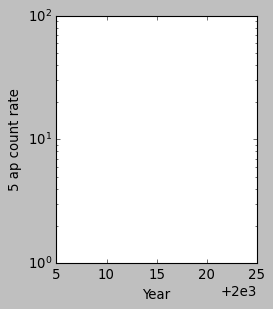

In [41]:
'''
# This shows the count rates over time
'''
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

filters=['uvw1']

for i, filter in enumerate(filters):

    index=filters.index(filter)
    ax = fig.add_subplot(2,3, index+1)
    ax.set_xlabel('Year')

    ax.set_ylabel('5 ap count rate')
    ax.axis([2005,2025,1, 100])
    ax.set_yscale('log')
    
    
    for j, field in enumerate(fields):
        for c in range(len(comps)):   
            #print(cr3[i,0,c,:])
            ax.errorbar(year[i,j,c,:], cr5[i,j,c,:],  marker='s', linestyle='none', mfc='blue',mec='blue', ms=2, mew=1, color='blue')
            currentlist=np.isfinite(cr5[i,j,c,:])
            npoints=currentlist.count(True)
            print(np.isfinite(cr5[i,j,c,:]))
            if npoints > 3:
                print(np.sum(npoints))
                print(cr5[i,j,c,:])
                m, b = np.polyfit(year[i,j,c,:], cr5[i,j,c,:], 1)
                plt.plot(x, m*x + b)
plt.yscale("log")
      
plt.savefig('UVOTcrs_year.png', dpi=300, bbox_inches='tight')
plt.show()

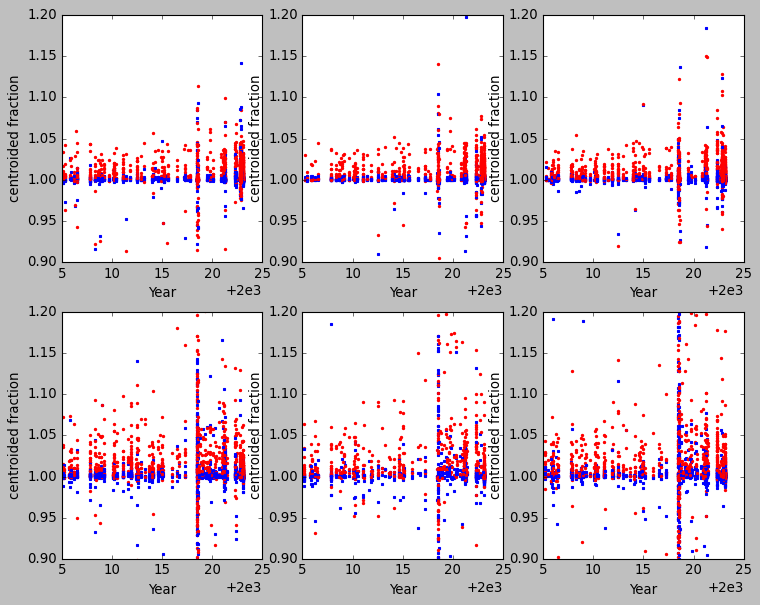

In [7]:
'''
# This shows the  difference between the photometry with and without centroiding
'''
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):

    index=filters.index(filter)
    ax = fig.add_subplot(2,3, index+1)
    ax.set_xlabel('Year')

    ax.set_ylabel('centroided fraction')
    ax.axis([2005,2025,0.9, 1.2])
    
   

    for j, field in enumerate(fields):
        for c in range(len(comps)):   
            #print(cr3[i,0,c,:])
            ax.errorbar(year[i,j,c,:], np.divide(cr5_centroid[i,j,c,:],cr5[i,j,c,:]),  marker='s', linestyle='none', mfc='blue',mec='blue', ms=2, mew=1, color='blue')
            ax.errorbar(year[i,j,c,:], np.divide(cr3_centroid[i,j,c,:],cr3[i,j,c,:]),  marker='o', linestyle='none', mfc='red',mec='red', ms=2, mew=1, color='red')

            #ax.errorbar(year[i,j,c,:], frameapcor[i,j,:], frameapcorscat[i,j,:] ,   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

        
plt.savefig('UVOTcentroid_year.png', dpi=300, bbox_inches='tight')
plt.show()

vv
bb
uu
w1
m2
w2


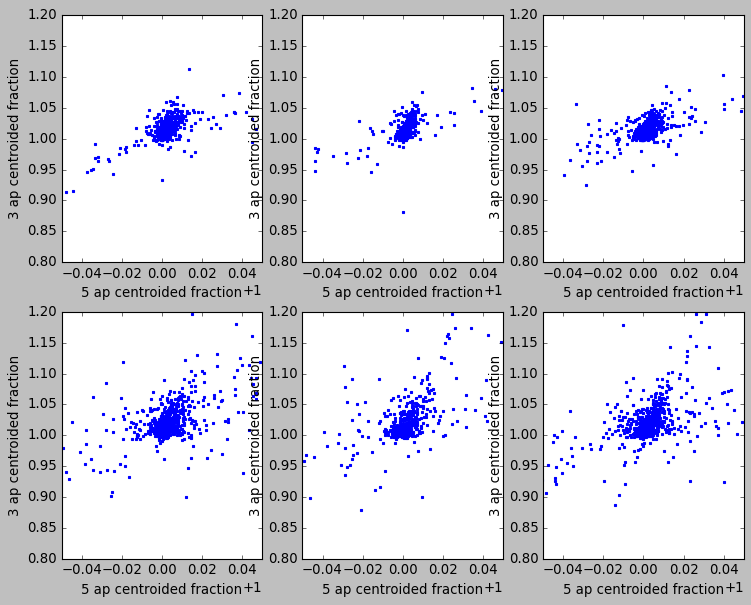

In [8]:
'''
# This shows the  difference between the photometry with and without centroiding
'''
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    print(filter)
    index=filters.index(filter)
    ax = fig.add_subplot(2,3, index+1)
    ax.set_xlabel('5 ap centroided fraction')

    ax.set_ylabel('3 ap centroided fraction')
    ax.axis([0.95,1.05,0.8, 1.2])
    
   

    for j, field in enumerate(fields):
        for c in range(len(comps)):   
            #print(cr3[i,0,c,:])
            ax.errorbar(np.divide(cr5_centroid[i,j,c,:],cr5[i,j,c,:]),np.divide(cr3_centroid[i,j,c,:],cr3[i,j,c,:]),  marker='s', linestyle='none', mfc='blue',mec='blue', ms=2, mew=1, color='blue')

            #ax.errorbar(year[i,j,c,:], frameapcor[i,j,:], frameapcorscat[i,j,:] ,   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

        
plt.savefig('UVOTcentroid_35.png', dpi=300, bbox_inches='tight')
plt.show()

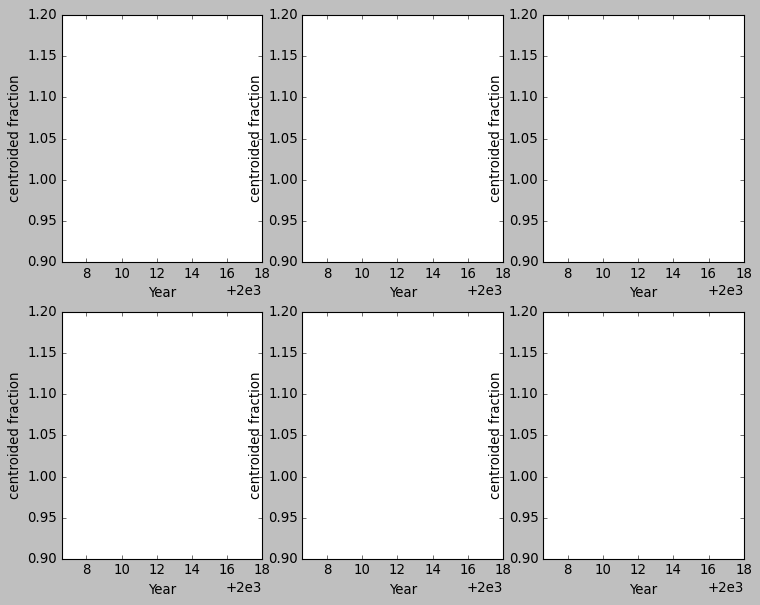

In [9]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0


for i, filter in enumerate(filters):

    index=filters.index(filter)
    ax = fig.add_subplot(2,3, index+1)
    ax.set_xlabel('Year')

    ax.set_ylabel('centroided fraction')
    ax.axis([2006.6,2018,0.9, 1.2])
    
   
    j=4
    field='SN2006jc'
    for c in range(len(comps)):   
        #print(cr3[i,0,c,:])
        ax.errorbar(year[i,j,c,:], np.divide(cr5_centroid[i,j,c,:],cr5[i,j,c,:]),  marker='s', linestyle='none', mfc='blue',mec='blue', ms=2, mew=1, color='blue')
        ax.errorbar(year[i,j,c,:], np.divide(cr3_centroid[i,j,c,:],cr3[i,j,c,:]),  marker='o', linestyle='none', mfc='red',mec='red', ms=2, mew=1, color='red')
        #print(cr5_centroid[i,j,c,:],cr5[i,j,c,:])
        divided=np.divide(cr5_centroid[i,j,c,:],cr5[i,j,c,:])
        #print(divided)
        if any(np.divide(cr5_centroid[i,j,c,:],cr5[i,j,c,:]))<1:
        
            the_filtered_list = list(entry for entry in divided if entry > 1)
            print('SN2006jc', c, where(np.divide(cr5_centroid[i,j,c,:],cr5[i,j,c,:]) <1))
#            print(the_filtered_list)
#        print(np.divide(cr5_centroid[i,j,c,np.isfinite(cr5_centroid[i,j,c,:])],cr5[i,j,c,np.isfinite(cr5[i,j,c,:])]),cr5_centroid[i,j,c,np.isfinite(cr5_centroid[i,j,c,:])] )
#        print( cr5_centroid[i,j,c,(cr5_centroid[i,j,c,:]<cr3_centroid[i,j,c,:] )])
                           
plt.savefig('UVOTcentroid_year.png', dpi=300, bbox_inches='tight')
plt.show()



vv
bb
uu
w1
m2
w2


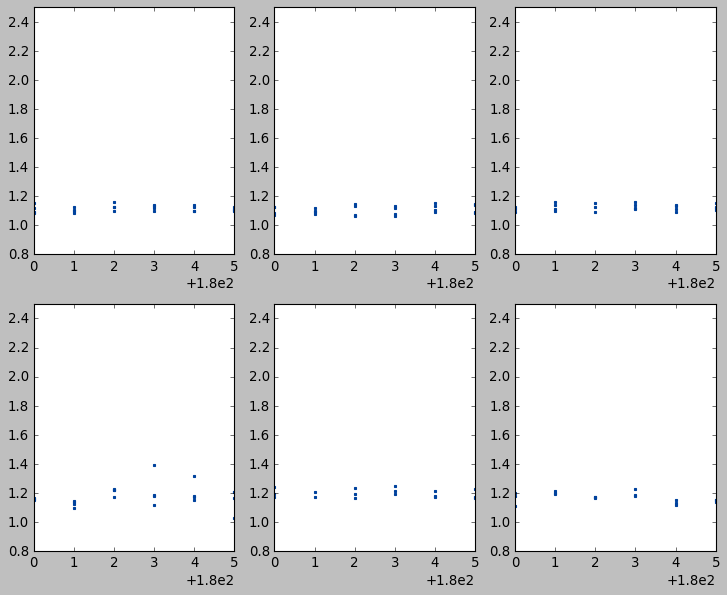

In [10]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    print(filter)
    index=filters.index(filter)
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.axis([180,185,0.8, 2.5])

    for j, field in enumerate(fields):
#        for c in range(len(comps)):   
        for c in range(7):   
  
            #print(cr3[i,0,c,:])
            ax.plot(np.divide(cr5[i,j,c,:],cr3[i,j,c,:]),   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

            #ax.errorbar(year[i,j,c,:], frameapcor[i,j,:], frameapcorscat[i,j,:] ,   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

        
plt.show()   

vv
bb
uu
w1
m2
w2


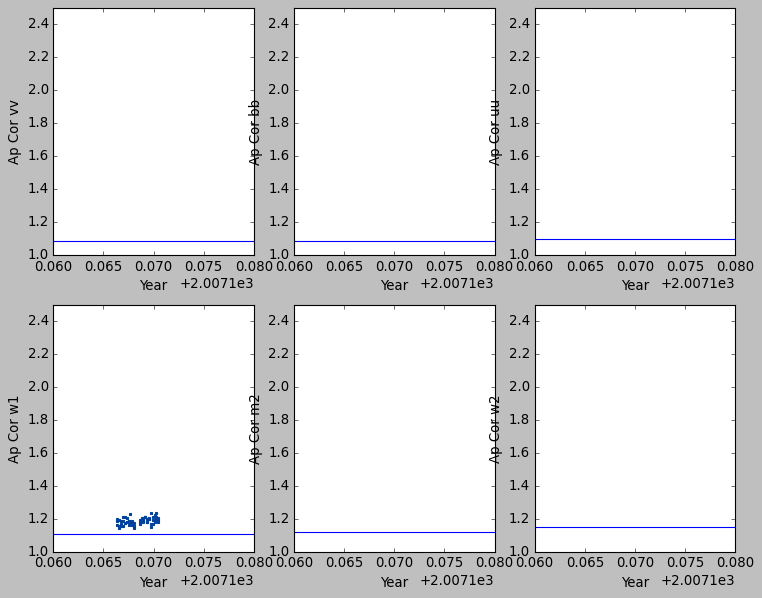

In [11]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    print(filter)
    index=filters.index(filter)
    apcorline=[apcor[index],apcor[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('Year')

    ax.set_ylabel('Ap Cor '+filter)
    ax.axis([2007.16,2007.18,1.0, 2.5])
    
    ax.plot([2005,2025],apcorline)
   
    

    for j, field in enumerate(fields):
        #for c in range(len(comps)):   
        for c in range(5):   
            #print(cr3[i,0,c,:])
            ax.errorbar(year[i,j,c,:], np.divide(cr5[i,j,c,:],cr3[i,j,c,:]), np.divide(cr5e[i,0,c,:],cr3[i,0,c,:]) ,   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

            #ax.errorbar(year[i,j,c,:], frameapcor[i,j,:], frameapcorscat[i,j,:] ,   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

        
plt.savefig('UVOTapcor_year.png', dpi=300, bbox_inches='tight')
plt.show()

The above was used to find that a few bad aperture corrections are from smeared frames or stars at the edge of a frame

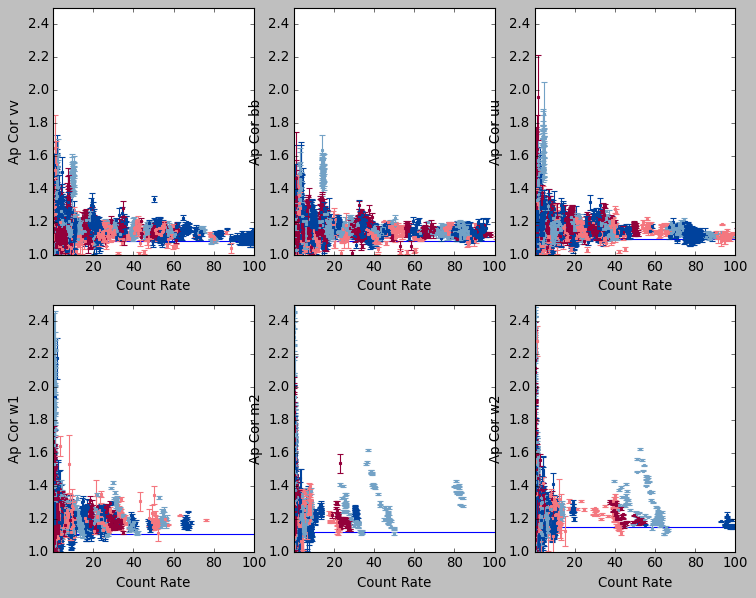

In [12]:


fig = plt.figure(figsize=(11, 8.5))





for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcor[index],apcor[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('Count Rate')

    ax.set_ylabel('Ap Cor '+filter)
    ax.axis([0.01,100,1, 2.5])
    
    ax.plot([0.01,100],apcorline)

    for j, field in enumerate(fields):
        fieldindex=j
        for c in range(len(comps)):   
            ax.errorbar(cr5[i,j,c,:], np.divide(cr5[i,j,c,:],cr3[i,j,c,:]), np.divide(cr5e[i,j,c,:],cr3[i,j,c,:]) ,   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

plt.savefig('UVOTapcor_cr.eps', dpi=300, bbox_inches='tight')
plt.show()

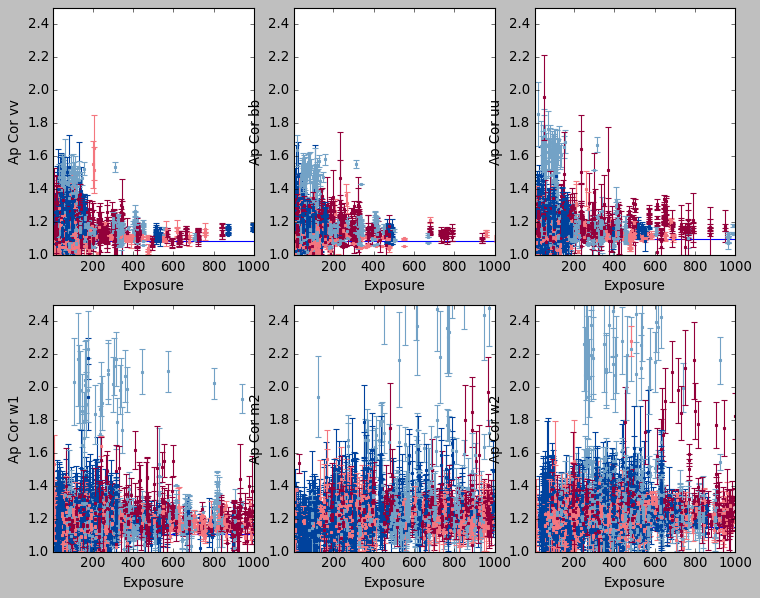

In [13]:
fig = plt.figure(figsize=(11, 8.5))

for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcor[index],apcor[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('Exposure')

    ax.set_ylabel('Ap Cor '+filter)
    ax.axis([5,1000,1, 2.5])
    
    ax.plot([0.01,1000],apcorline)

    for j, field in enumerate(fields):
        fieldindex=j
        for c in range(len(comps)):   
            ax.errorbar(exposure[i,j,c,:], cr5[i,j,c,:]/cr3[i,j,c,:], cr5e[i,j,c,:]/cr3[i,j,c,:] ,   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

plt.savefig('UVOTapcor_exp.png', dpi=300, bbox_inches='tight')
plt.show()

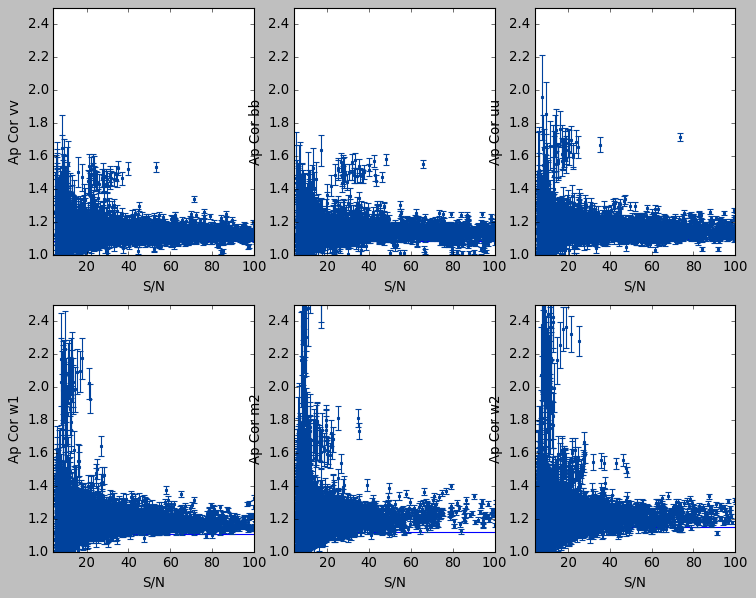

In [14]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcor[index],apcor[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('S/N')

    ax.set_ylabel('Ap Cor '+filter)
    ax.axis([4,100,1, 2.5])
    
    ax.plot([4,200],apcorline)

    for j, field in enumerate(fields):
        for c in range(len(comps)):   
            ax.errorbar(cr5[i,j,c,:]/cr5e[i,j,c,:], cr5[i,j,c,:]/cr3[i,j,c,:], cr5e[i,j,c,:]/cr3[i,j,c,:] ,   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

plt.savefig('UVOTapcor_sn.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
cr3[cr5/cr3>1.4]=np.nan
cr3[cr3/cr3e<20]=np.nan
       
  

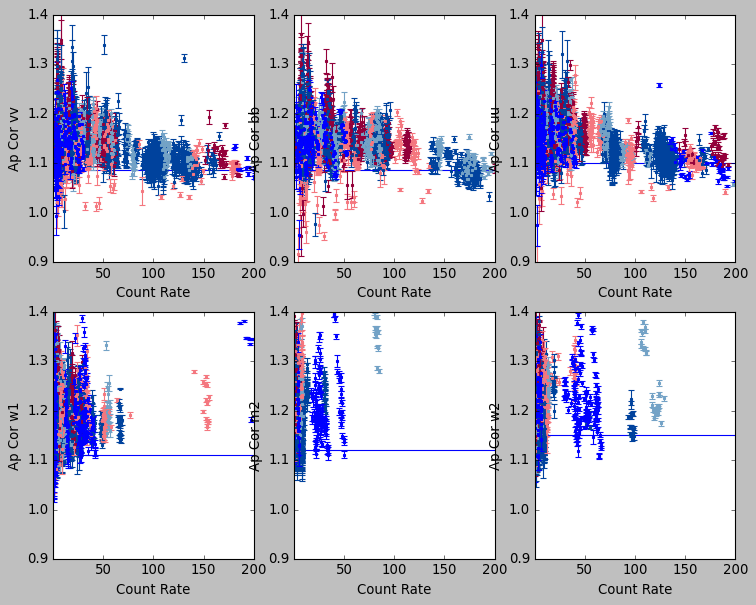

In [16]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcor[index],apcor[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('Count Rate')

    ax.set_ylabel('Ap Cor '+filter)
    ax.axis([0.1,200,0.9, 1.4])
    
    ax.plot([0.1,200],apcorline)
    #ax.plt.yscale("log")
    for j, field in enumerate(fields):
        for c in range(len(comps)):   
            if "WD" in field: ax.errorbar(cr5[i,j,c,:], cr5[i,j,c,:]/cr3[i,j,c,:], cr5e[i,j,c,:]/cr3[i,j,c,:] ,   marker='s', linestyle='none', mfc='blue',mec='blue', ms=2, mew=1, color='blue')
            if "SN" in field: ax.errorbar(cr5[i,j,c,:], cr5[i,j,c,:]/cr3[i,j,c,:], cr5e[i,j,c,:]/cr3[i,j,c,:] ,   marker='s', linestyle='none', mfc=colors[j],mec=colors[j], ms=2, mew=1, color=colors[j])

        
plt.savefig('UVOTapcor_cr.png', dpi=300, bbox_inches='tight')
plt.show()

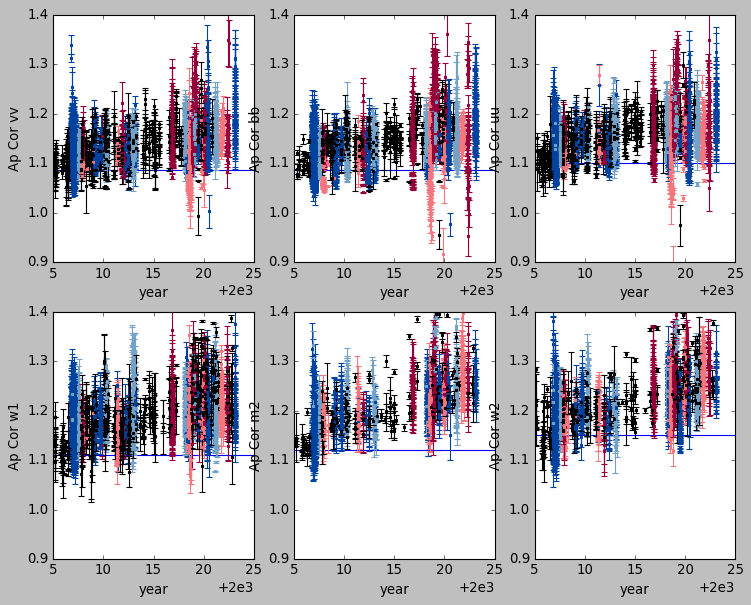

In [17]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcor[index],apcor[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('year')

    ax.set_ylabel('Ap Cor '+filter)
    ax.axis([2005, 2025,0.9, 1.4])
    
    ax.plot([2005, 2025],apcorline)

    for j, field in enumerate(fields):
        for c in range(len(comps)):  
            if "WD" in field: ax.errorbar(year[i,j,c,:], cr5[i,j,c,:]/cr3[i,j,c,:], cr5e[i,j,c,:]/cr3[i,j,c,:] ,   marker='s', linestyle='none', mfc='black',mec='black', ms=2, mew=1, color='black')
            if "SN" in field: ax.errorbar(year[i,j,c,:], cr5[i,j,c,:]/cr3[i,j,c,:], cr5e[i,j,c,:]/cr3[i,j,c,:] ,   marker='s', linestyle='none', mfc=colors[j],mec=colors[j], ms=2, mew=1, color=colors[j])

        
plt.savefig('UVOTapcor_year.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
'''
indices = np.argwhere((cr5/cr3 > 1.3) & (cr5e/cr3 < 0.2))
for index in indices:
    #print(index)
    #print(index[1])
    print('edit compdata/'+fields[index[1]]+'_'+filters[index[0]]+'_senstest_comp'+comps[index[2]]+'_more.dat',  index[3]+1)
    print('ds9 -region load '+fields[index[1]]+'_comp'+comps[index[2]]+'.reg '+fields[index[1]]+'_'+filters[index[0]]+'.img\['+str(index[3]+1)+'\] &')
'''

"\nindices = np.argwhere((cr5/cr3 > 1.3) & (cr5e/cr3 < 0.2))\nfor index in indices:\n    #print(index)\n    #print(index[1])\n    print('edit compdata/'+fields[index[1]]+'_'+filters[index[0]]+'_senstest_comp'+comps[index[2]]+'_more.dat',  index[3]+1)\n    print('ds9 -region load '+fields[index[1]]+'_comp'+comps[index[2]]+'.reg '+fields[index[1]]+'_'+filters[index[0]]+'.img\\['+str(index[3]+1)+'\\] &')\n"

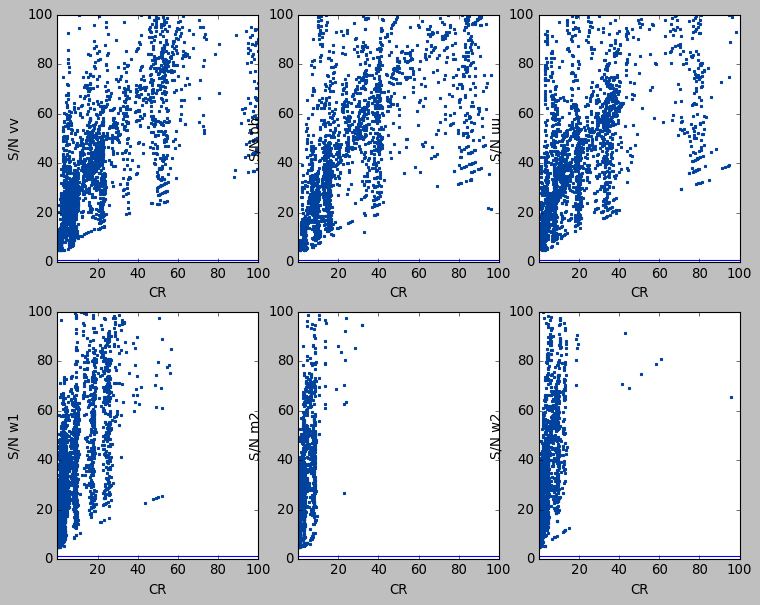

In [19]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcor[index],apcor[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('CR')

    ax.set_ylabel('S/N '+filter)
    ax.axis([0.01,100,0,100])
    
    ax.plot([0.01,100],apcorline)

    for j, field in enumerate(fields):
        for c in range(len(comps)):   
            ax.errorbar(cr5[i,j,c,:], cr5[i,j,c,:]/cr5e[i,j,c,:],   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

plt.savefig('UVOTcr_sn.png', dpi=300, bbox_inches='tight')
plt.show()

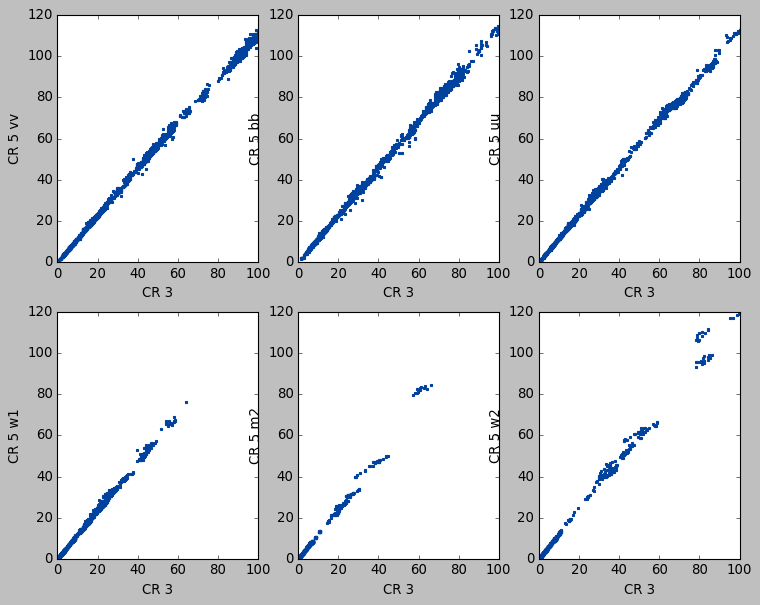

In [20]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcor[index],apcor[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('CR 3')

    ax.set_ylabel('CR 5 '+filter)
    ax.axis([0.0,100,0,120])
    
    #ax.plot([0.0,100],apcorline)

    for j, field in enumerate(fields):
        for c in range(len(comps)):   
            ax.errorbar(cr3[i,j,c,:], cr5[i,j,c,:],   marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

plt.savefig('UVOTcr_cr3vcr5.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
apcor_array=cr5[3]/cr3[3]
k=1
np.set_printoptions(threshold=200, linewidth=200)
idx = np.argpartition(apcor_array, k)
print(cr3[2,:,2,2])

[     nan      nan      nan      nan  16.9191  78.9815  21.4364      nan  66.4141  61.7416      nan  22.5516      nan  21.543       nan      nan 153.094       nan      nan  11.6423      nan      nan
      nan      nan      nan      nan      nan      nan      nan      nan      nan      nan      nan]


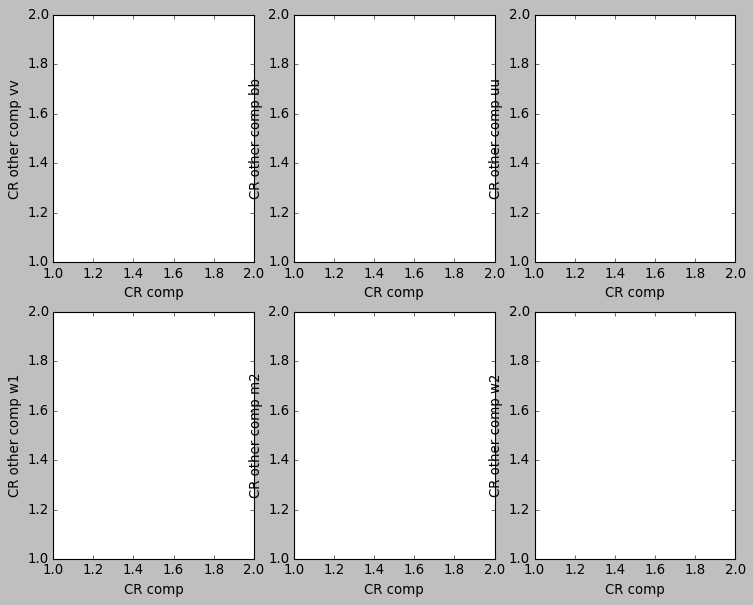

In [22]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcor[index],apcor[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('CR comp')

    ax.set_ylabel('CR other comp '+filter)
    ax.axis([1.0,2,1,2])
    
    #ax.plot([0.0,100],apcorline)

    for j, field in enumerate(fields):
        for c in range(len(comps)):   
            #ax.errorbar( cr5[i,j,c,:]/cr3[i,j,c,:], cr5[i,j,c+1,:]/cr3[i,j,c+1,:],  marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])
            f=2
plt.savefig('UVOTcr_cr.png', dpi=300, bbox_inches='tight')
plt.show()

vv
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
bb
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
uu
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
w1
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
m2
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
w2
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


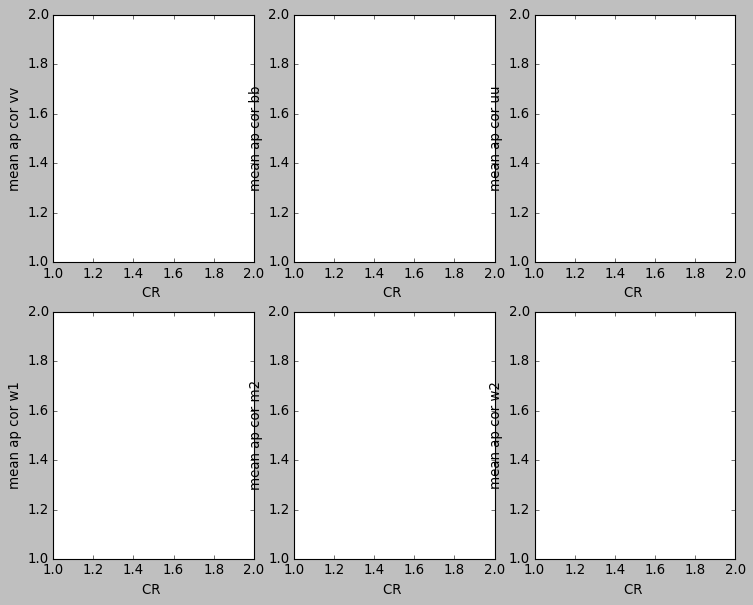

In [23]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    print(filter)
    index=filters.index(filter)
    apcorline=[apcor[index],apcor[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('CR ')

    ax.set_ylabel('mean ap cor '+filter)
    ax.axis([1.0,2,1,2])
    
    #ax.plot([0.0,100],apcorline)
    print(compapcor[i,0,:])
    ax.errorbar( cr5[i,0,:,0], compapcor[i,0,:], compapcorscat[i,0,:],  marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

    

    
plt.savefig('UVOTcr_compmean.png', dpi=300, bbox_inches='tight')
plt.show()





ValueError: 'x' and 'y' must have the same size

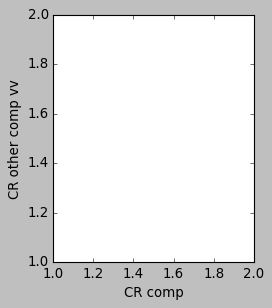

In [24]:
fig = plt.figure(figsize=(11, 8.5))

fieldindex=0

for i, filter in enumerate(filters):
    #print(filter)
    index=filters.index(filter)
    apcorline=[apcor[index],apcor[index]]
    ax = fig.add_subplot(2,3, index+1)
    #plt.scatter([mjd],[cr3])
    ax.set_xlabel('CR comp')

    ax.set_ylabel('CR other comp '+filter)
    ax.axis([1.0,2,1,2])
    
    #ax.plot([0.0,100],apcorline)

    ax.errorbar( cr5[i,0,:,0], frameapcor[i,0,:], frameapcorscat[i,0,:],  marker='s', linestyle='none', mfc=colors[fieldindex],mec=colors[fieldindex], ms=2, mew=1, color=colors[fieldindex])

plt.savefig('UVOTcr_framemean.png', dpi=300, bbox_inches='tight')
plt.show()




In [ ]:
print(telapse)

In [ ]:
print(cr5)